# Group 1 Capstone Project Work
### Make sure to make / checkout your own branch before making changes

# Maddie Hince

In [71]:
import pandas as pd
import sqlite3

conn = sqlite3.connect('zippedData/im.db')

In [102]:
ratings_df = pd.read_sql("""SELECT movie_ratings.movie_id, movie_ratings.averagerating, 
                                   movie_ratings.numvotes, movie_basics.primary_title, 
                                   movie_basics.start_year, movie_basics.genres 
                            FROM movie_ratings
                            JOIN movie_basics USING(movie_id)
                            WHERE movie_basics.start_year >= 2010""", conn)

In [103]:
ratings_df.dropna(how='any', axis=0, inplace=True)

In [104]:
def clean_genres(genres):
    genres = str(genres)
    genres_list = sorted(genres.lower().split(','))
    return ','.join(list(map(str, genres_list)))

In [105]:
ratings_df['genres'] = ratings_df['genres'].apply(clean_genres)
ratings_df.head()

,movie_id,averagerating,numvotes,primary_title,start_year,genres
0,tt0063540,7.0,77,Sunghursh,2013,"action,crime,drama"
1,tt0066787,7.2,43,One Day Before the Rainy Season,2019,"biography,drama"
2,tt0069049,6.9,4517,The Other Side of the Wind,2018,drama
3,tt0069204,6.1,13,Sabse Bada Sukh,2018,"comedy,drama"
4,tt0100275,6.5,119,The Wandering Soap Opera,2017,"comedy,drama,fantasy"


In [106]:
ratings_df['genres'].value_counts()
sorted_by_avg = ratings_df.groupby('genres').mean().sort_values(by='averagerating', ascending=False)

count       923.000000
mean       4378.464914
std       13265.696554
min           5.000000
25%          62.250000
50%         322.200000
75%        2469.010861
max      181285.417323
Name: numvotes, dtype: float64

In [107]:
# filter out movie genres with less than 62 total votes
sorted_avg_higher_votes = sorted_by_avg[sorted_by_avg['numvotes'] >= 62].head(15)
sorted_avg_higher_votes.reset_index(inplace=True)

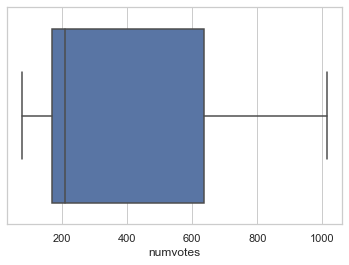

In [134]:
# visualizations
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style = 'whitegrid')

# outliers removed to improve quartile readability 
fig, ax = plt.subplots()
sns.boxplot(x = sorted_avg_higher_votes['numvotes'], showfliers=False);


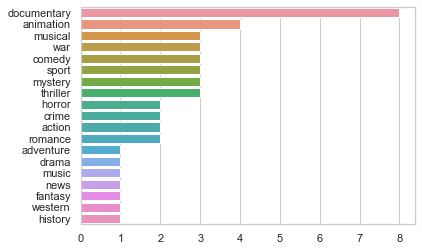

In [172]:
# make count of each of these individual genres in dictionary
top_genres = {}
for genre in sorted_avg_higher_votes['genres'].value_counts().index:
    genre_list = genre.split(',')
    for item in genre_list:
        if item not in top_genres:
            top_genres[item] = 1
        elif item in top_genres:
            top_genres[item] += 1
top_genres = dict(sorted(top_genres.items(), key = lambda x: x[1], reverse=True))

# bar chart showing 15 highest-rated movie genres with more than 62 total votes
sns.barplot(x = list(top_genres.values()), y = list(top_genres.keys()));

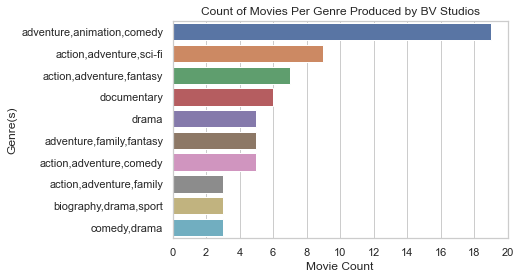

In [142]:
# dataframe with movie titles and studio
movie_gross_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_gross_df['title'] = movie_gross_df['title'].str.lower()

# dataframe from database with movie titles and genres
movie_basics_df = pd.read_sql("""SELECT *
                                 FROM movie_basics
                                 WHERE start_year >= 2010""", conn)
movie_basics_df['primary_title'] = movie_basics_df['primary_title'].str.lower()

# inner join dataframes on title (movie_gross_df), primary_title (movie_basics_df)
movie_genre_studio_df = pd.merge(movie_gross_df, movie_basics_df, 
                                 left_on='title', right_on='primary_title',
                                 how='inner')
# drop movies with no genres
movie_genre_studio_df.dropna(subset=['genres'], inplace=True)
# clean genre string for each row
movie_genre_studio_df['genres'] = movie_genre_studio_df['genres'].apply(clean_genres)

# put movies from highest-performing studio into a dataframe
bv_studio_movies = movie_genre_studio_df[movie_genre_studio_df['studio'] == 'BV']

# bar chart showing number of movies per genre for BV studios
fig, ax = plt.subplots()
sns.countplot(data=bv_studio_movies, y='genres', 
              order=bv_studio_movies['genres'].value_counts().iloc[:10].index,
              ax = ax)
ax.set_xticks(range(0,21,2))
ax.set_title('Count of Movies Per Genre Produced by BV Studios')
ax.set_xlabel('Movie Count')
ax.set_ylabel('Genre(s)');

# Cat Murad

# Elijah Soba

# Luis Estrada 

# Kilmar Lazo 

# Michael Eugene